In [1]:
# Stop warnings
# -------------
import warnings
warnings.filterwarnings("ignore")

# General imports
# ---------------
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# MRI imports
# -----------
import nibabel as nb
import cortex

# Functions import
# ----------------
from utils import draw_cortex_vertex, set_pycortex_config_file

# GLM imports
# ----------------
from nilearn import image, datasets, plotting, surface
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_anat, plot_img

In [15]:
# Get inputs
# ----------
#mount_dir = '/media/scratchms/data/PredictEye' #sys.argv[1]
mount_dir = '/Users/martinszinte/disks/meso_S/data/PredictEye/'
subject = 'sub-01'#sys.argv[2]
session = 'ses-01'
task = 'SacLoc'
space = 'T1w'
run = 'run-1'
preproc = 'fmriprep_dct'
save_svg = 0
if save_svg == 1: save_svg = True
else: save_svg = False
    
    
# Define analysis parameters
# --------------------------
with open('../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)

# Define folder
# -------------
xfm_name = "identity.fmriprep"
base_dir = "{}".format(mount_dir)
deriv_dir = "{}/pp_data/{}/glm/fit".format(base_dir,subject)

task_name = [task[:3], 'Fix' ]


tr_dur=1.2

file_img = "{cwd}/pp_data/{subject}/func/{subject}_task-{task}_space-{space}_{preproc}_avg.nii.gz".\
                format(cwd=mount_dir, subject=subject,task=task,space=space,preproc=preproc)

file_mask_img = '{cwd}/deriv_data/fmriprep/fmriprep/{subject}/{session}/func/{subject}_{session}_task-{task}_{run}_space-{space}_desc-brain_mask.nii.gz'.\
                format(cwd=mount_dir, subject=subject, session=session, task=task, run=run, space=space)


output_folder = '{cwd}/pp_data/{subject}/glm/fit/'.format(cwd=mount_dir, subject=subject)


try:
    os.makedirs(output_folder)
except:
    pass


# create design table
onset = [    0*tr_dur,
             16*tr_dur,
             (16+32)*tr_dur,
             (16+32+16)*tr_dur,
             (16+32+16+32)*tr_dur,
             (16+32+16+32+16)*tr_dur,
             (16+32+16+32+16+32)*tr_dur,
             (16+32+16+32+16+32+16)*tr_dur,
             (16+32+16+32+16+32+16+32)*tr_dur]

duration = [ 16*tr_dur,
             32*tr_dur,
             16*tr_dur,
             32*tr_dur,
             16*tr_dur,
             32*tr_dur,
             16*tr_dur,
             32*tr_dur,
             16*tr_dur,
             ]

trial_type = [task_name[1],task_name[0],task_name[1],task_name[0],
              task_name[1],task_name[0],task_name[1],task_name[0],task_name[1]]

data = {'onset':onset,
        'duration':duration,
        'trial_type':trial_type}

events_run1_glm = pd.DataFrame(data)


# first level GLM
fmri_img = file_img
output_fn = '{output_folder}{subject}_task-{task}_space-{space}_{preproc}_deriv.nii.gz'.\
            format(output_folder=output_folder, subject=subject,task=task,space=space,preproc=preproc)
mask_img = nb.load(file_mask_img)

fmri_glm = FirstLevelModel(t_r=tr_dur,
                        noise_model='ar1',
                        standardize=False,
                        hrf_model='spm',
                        drift_model=None,
                        mask_img=mask_img)

fmri_glm = fmri_glm.fit(fmri_img, events_run1_glm)

# design matrix
design_matrix = fmri_glm.design_matrices_[0]
# plot_design_matrix(design_matrix)
# plt.show()

# contrast
exec('conditions = { task_name[1]: np.array([1., 0., 0.]), task_name[0]: np.array([0., 1., 0.])}')

contrast = conditions[task_name[0]] - conditions[task_name[1]]
# plotting.plot_contrast_matrix(contrast, design_matrix=design_matrix)

eff_map = fmri_glm.compute_contrast(contrast,
                                    output_type='effect_size')

z_map = fmri_glm.compute_contrast(contrast,
                                    output_type='z_score')

p_map = 1 - stats.norm.cdf(abs(z_map.dataobj))

# stats maps
fdr_map, th = threshold_stats_img(z_map, alpha=0.01, height_control='fdr')
fdr_cluster10_map, th = threshold_stats_img(z_map, alpha=0.01, height_control='fdr', cluster_threshold=10)
fdr_cluster50_map, th = threshold_stats_img(z_map, alpha=0.01, height_control='fdr', cluster_threshold=50)
fdr_cluster100_map, th = threshold_stats_img(z_map, alpha=0.01, height_control='fdr', cluster_threshold=100)

# Save results
img = nb.load(file_img)
deriv = np.zeros((img.shape[0],img.shape[1],img.shape[2],6))*np.nan
deriv[...,0]  = z_map.dataobj
deriv[...,1]  = p_map
deriv[...,2]  = fdr_map.dataobj
deriv[...,3]  = fdr_cluster10_map.dataobj
deriv[...,4]  = fdr_cluster50_map.dataobj
deriv[...,5]  = fdr_cluster100_map.dataobj

deriv = deriv.astype(np.float32)
new_img = nb.Nifti1Image(dataobj = deriv, affine = img.affine, header = img.header)
new_img.to_filename(output_fn)

In [16]:
# Set pycortex db and colormaps
# -----------------------------
set_pycortex_config_file(base_dir)


depth = 1
thick = 1
sampler = 'nearest'
with_curvature = True
with_labels = False
with_colorbar = False
with_borders = False 
curv_brightness = 0.85
curv_contrast = 0.25
add_roi = False


z_map = deriv[...,0].T
p_map = deriv[...,1].T
fdr_map = deriv[...,2].T
fdr_c10_map = deriv[...,3].T
fdr_c50_map = deriv[...,4].T
fdr_c100_map = deriv[...,5].T


Background RRGGBBAA: ffffff00
Area 0:0:2191.77:1024 exported to 2192 x 1024 pixels (96 dpi)


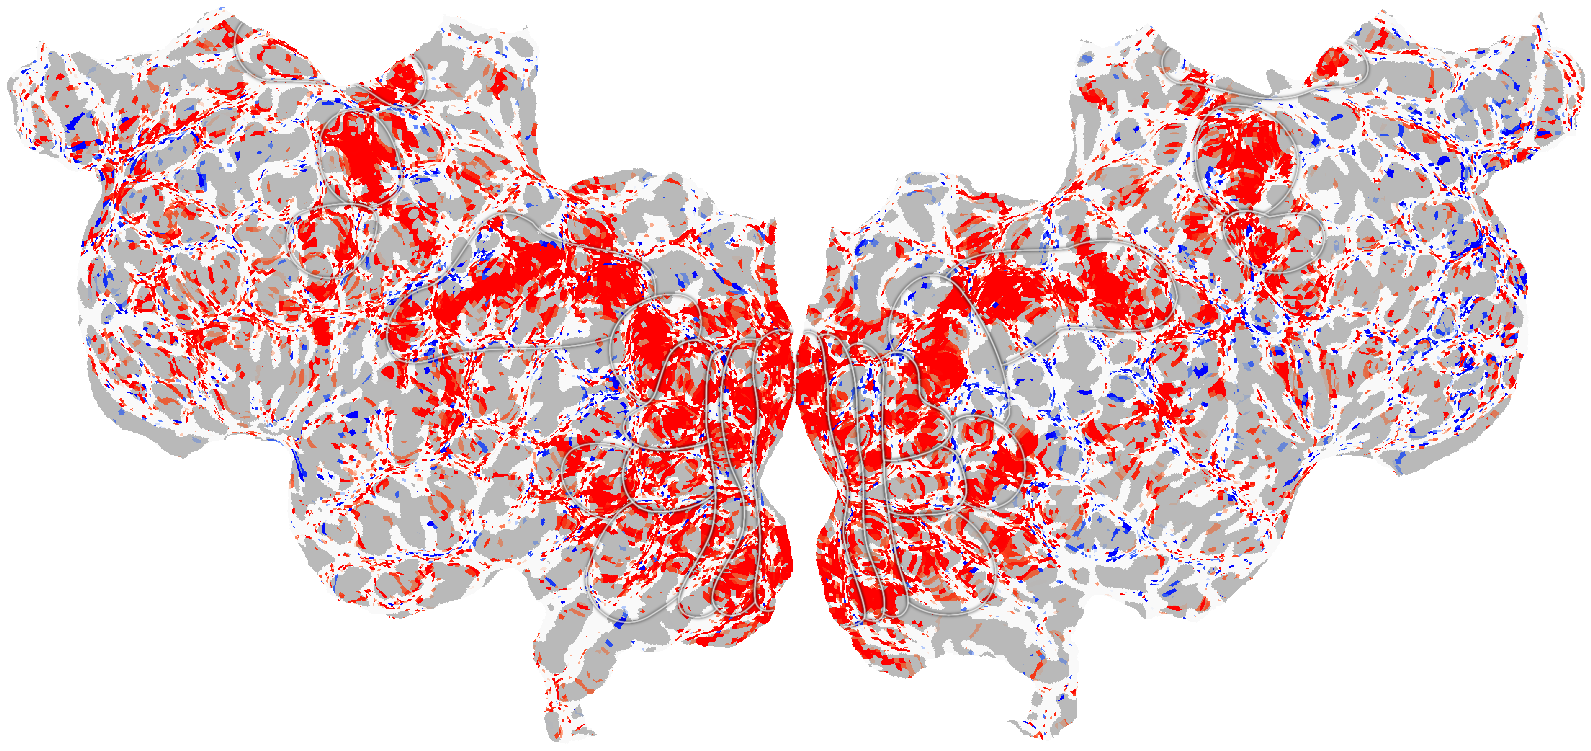

In [17]:
cmap = 'BuWtRd_alpha'

volume = cortex.Volume2D(dim1=z_map,
                         dim2=1-p_map,
                         subject=subject,
                         xfmname=xfm_name,
                         description='GLM: Sac vs. Fix',
                         cmap=cmap,
                         vmin=-3.5,
                         vmax=3.5,
                         vmin2=1-0.01,
                         vmax2=1-0.0001
                        )
volume_fig = cortex.quickshow(  braindata = volume,
                                depth = depth,
                                thick = thick,
                                sampler = sampler,
                                with_curvature = with_curvature,
                                with_labels = with_labels,
                                with_colorbar = with_colorbar,
                                with_borders = with_borders,
                                curvature_brightness = curv_brightness,
                                curvature_contrast = curv_contrast)


Background RRGGBBAA: ffffff00
Area 0:0:2191.77:1024 exported to 2192 x 1024 pixels (96 dpi)


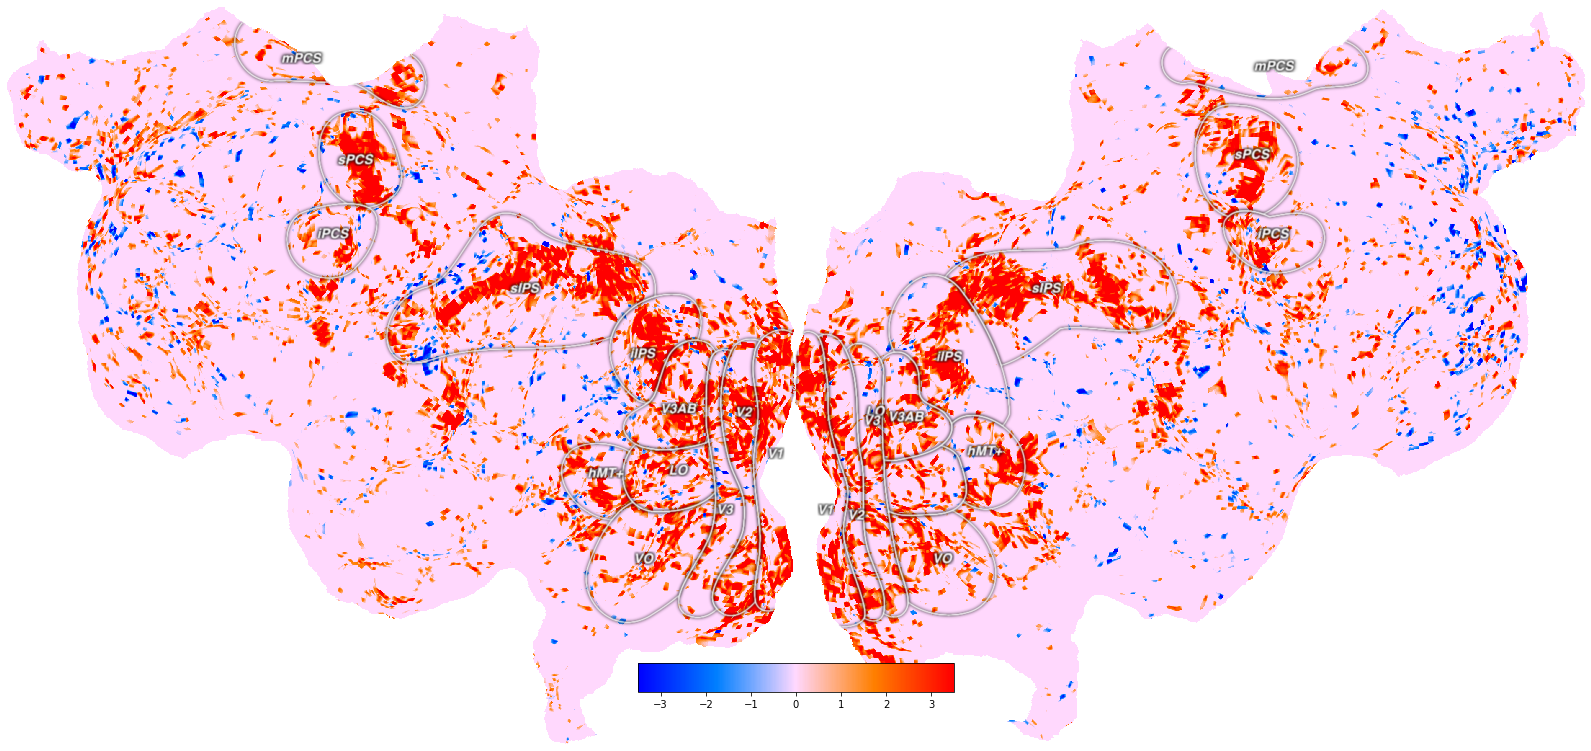

In [18]:
cmap = 'BuWtRd'

volume = cortex.Volume(data=fdr_map,
                        subject=subject,
                         xfmname=xfm_name,
                         description='GLM: Sac vs. Fix',
                         cmap=cmap,
                         vmin=-3.5,
                         vmax=3.5,
                        )

volume_fig = cortex.quickshow(  braindata = volume)

Background RRGGBBAA: ffffff00
Area 0:0:2191.77:1024 exported to 2192 x 1024 pixels (96 dpi)


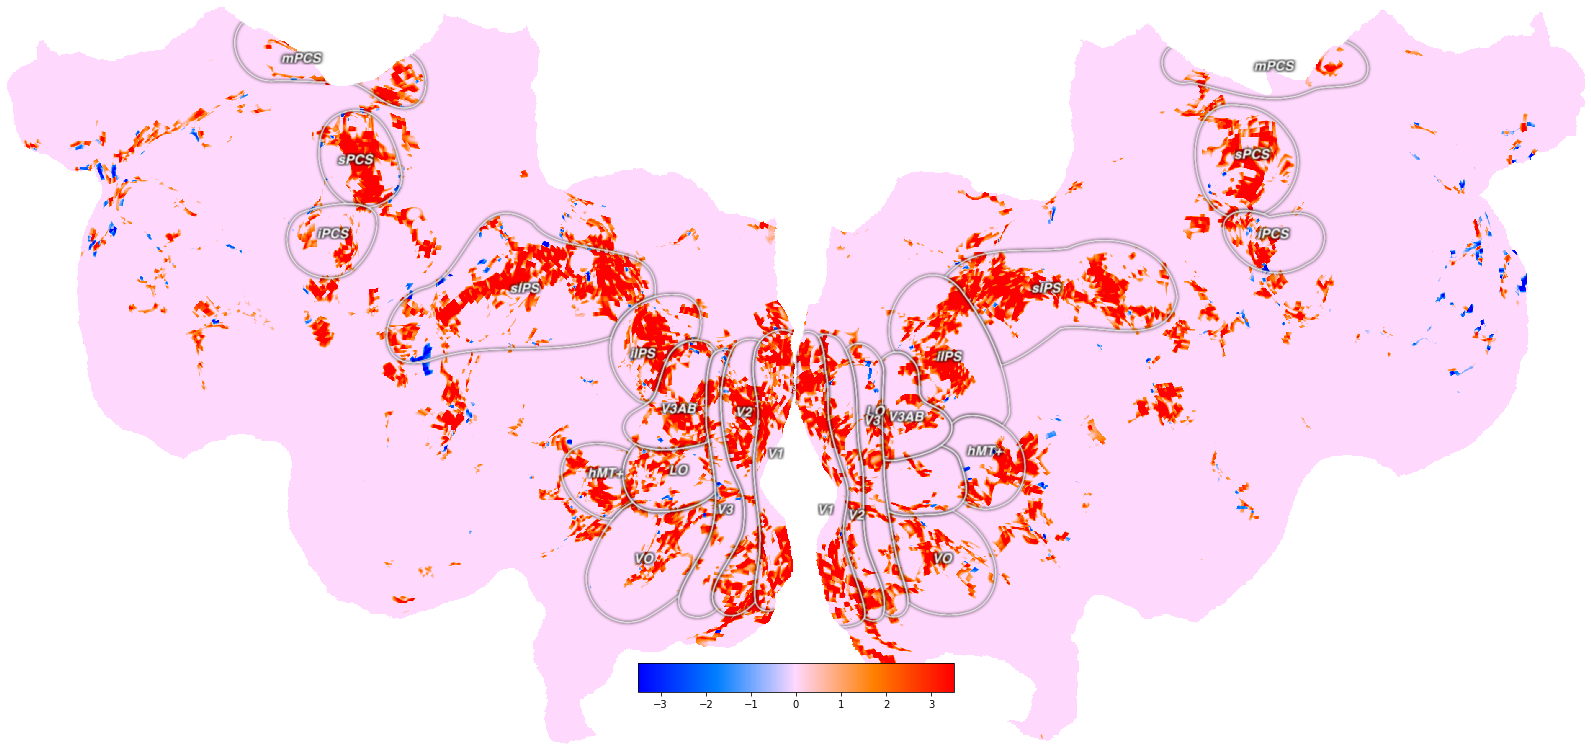

In [19]:
cmap = 'BuWtRd'

volume = cortex.Volume(data=fdr_c10_map,
                        subject=subject,
                         xfmname=xfm_name,
                         description='GLM: Sac vs. Fix',
                         cmap=cmap,
                         vmin=-3.5,
                         vmax=3.5,
                        )

volume_fig = cortex.quickshow(  braindata = volume)

Background RRGGBBAA: ffffff00
Area 0:0:2191.77:1024 exported to 2192 x 1024 pixels (96 dpi)


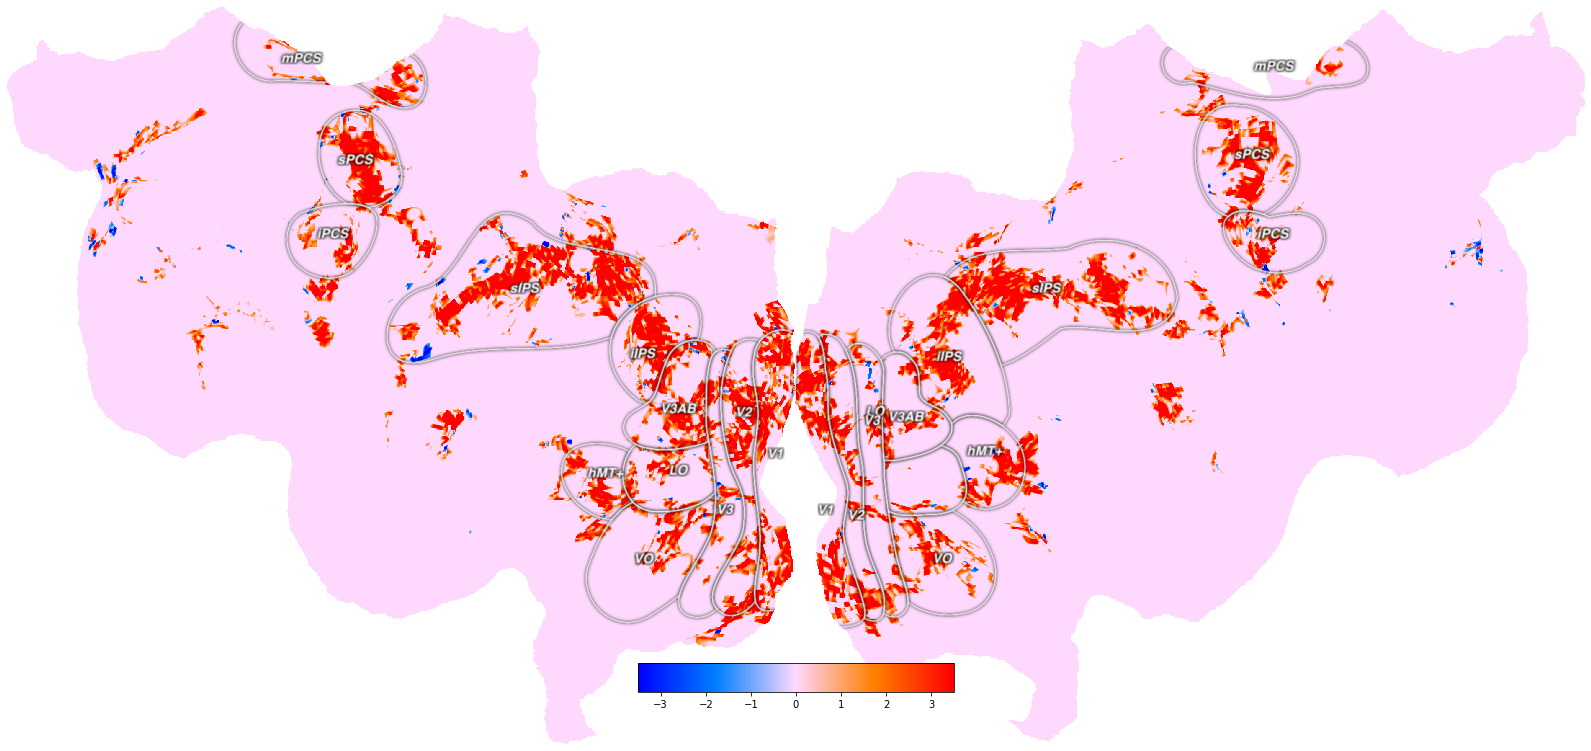

In [20]:
cmap = 'BuWtRd'

volume = cortex.Volume(data=fdr_c100_map,
                        subject=subject,
                         xfmname=xfm_name,
                         description='GLM: Sac vs. Fix',
                         cmap=cmap,
                         vmin=-3.5,
                         vmax=3.5,
                        )

volume_fig = cortex.quickshow(  braindata = volume)

Background RRGGBBAA: ffffff00
Area 0:0:2191.77:1024 exported to 2192 x 1024 pixels (96 dpi)


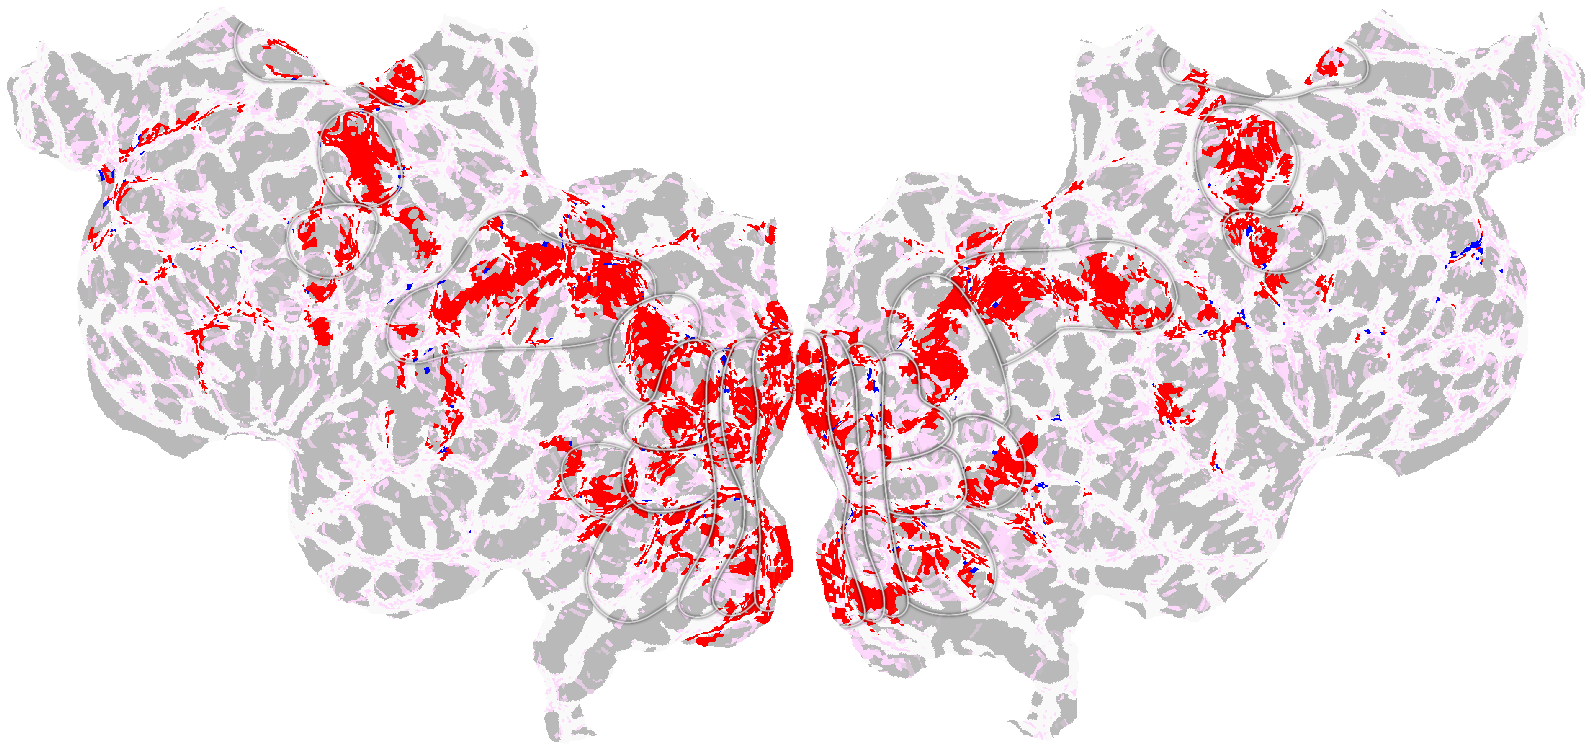

In [23]:
cmap = 'BuWtRd_alpha'

volume = cortex.Volume2D(dim1=fdr_c50_map,
                         dim2=1-p_map,
                         subject=subject,
                         xfmname=xfm_name,
                         description='GLM: Sac vs. Fix',
                         cmap=cmap,
                         vmin=-3.5,
                         vmax=3.5,
                         vmin2=1-0.01,
                         vmax2=1-0.0001
                        )
volume_fig = cortex.quickshow(  braindata = volume,
                                depth = depth,
                                thick = thick,
                                sampler = sampler,
                                with_curvature = with_curvature,
                                with_labels = with_labels,
                                with_colorbar = with_colorbar,
                                with_borders = with_borders,
                                curvature_brightness = curv_brightness,
                                curvature_contrast = curv_contrast)


Background RRGGBBAA: ffffff00
Area 0:0:2191.77:1024 exported to 2192 x 1024 pixels (96 dpi)


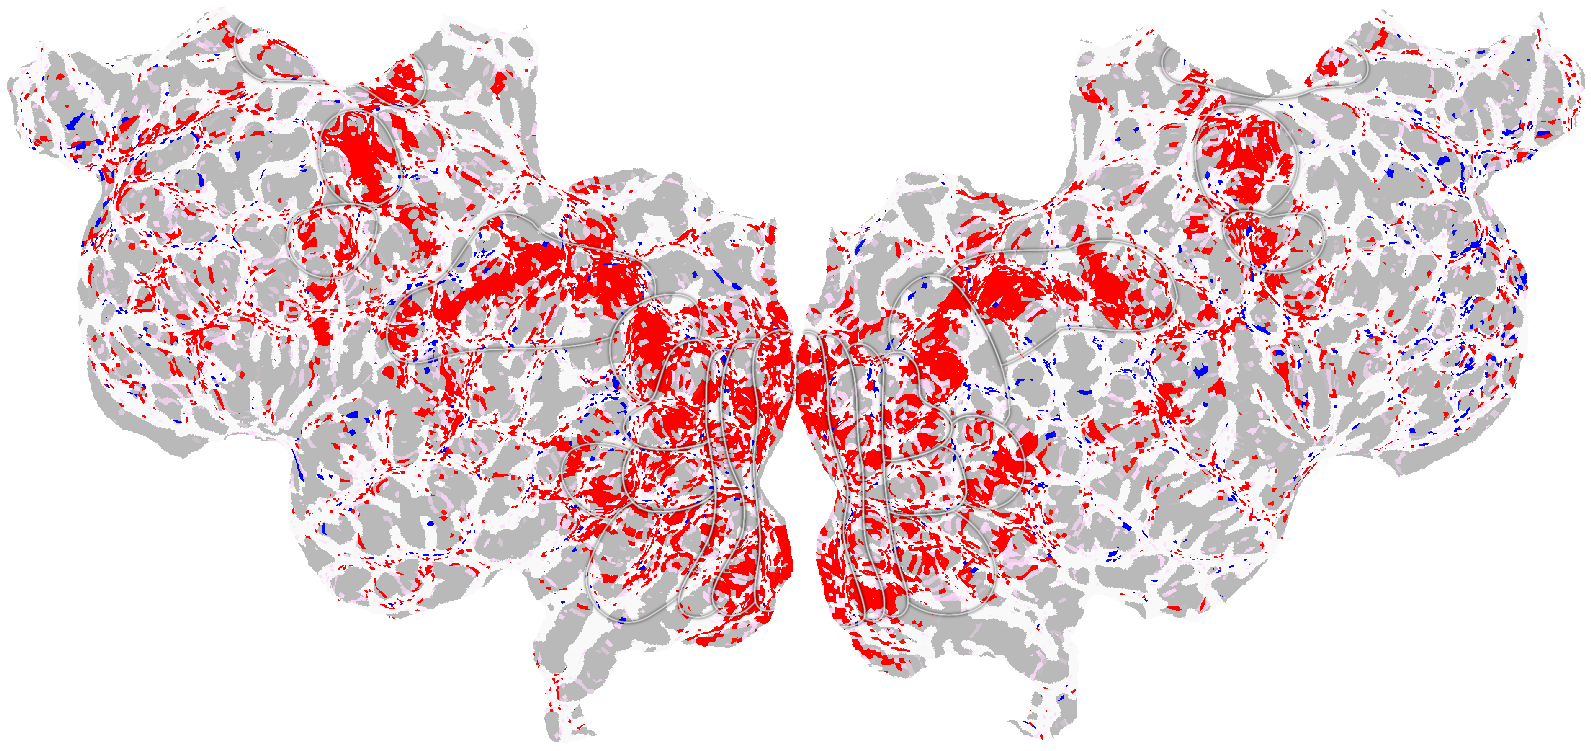

In [25]:
cmap = 'BuWtRd_alpha'

volume = cortex.Volume2D(dim1=fdr_map,
                         dim2=1-p_map,
                         subject=subject,
                         xfmname=xfm_name,
                         description='GLM: Sac vs. Fix',
                         cmap=cmap,
                         vmin=-3.5,
                         vmax=3.5,
                         vmin2=1-0.01,
                         vmax2=1-0.0001
                        )
volume_fig = cortex.quickshow(  braindata = volume,
                                depth = depth,
                                thick = thick,
                                sampler = sampler,
                                with_curvature = with_curvature,
                                with_labels = with_labels,
                                with_colorbar = with_colorbar,
                                with_borders = with_borders,
                                curvature_brightness = curv_brightness,
                                curvature_contrast = curv_contrast)
